In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import os
import time

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.model_selection as model_selection

import tensorflow as tf
from tensorflow import keras

import h5py

In [2]:
# Set your own project id here
# PROJECT_ID = 'your-google-cloud-project'
# from google.cloud import storage
# storage_client = storage.Client(project=PROJECT_ID)

In [3]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [4]:
def decode(serialized_example):
    feats = tf.io.parse_single_example(serialized_example, features={'x1': tf.io.FixedLenFeature([], tf.string),
                                                                     'x2': tf.io.FixedLenFeature([], tf.string),
                                                                     'x3': tf.io.FixedLenFeature([], tf.string),
                                                                     'y': tf.io.FixedLenFeature([], tf.string)})

    x1 = tf.io.decode_raw(feats['x1'], tf.float64)
    x1 = tf.reshape(x1, [32,37,32,424])

    x2 = tf.io.decode_raw(feats['x2'], tf.float64)
    x2.set_shape((1378))

    x3 = tf.io.decode_raw(feats['x3'], tf.float64)
    x3.set_shape((26))

    y = tf.io.decode_raw(feats['y'], tf.float64)
    y.set_shape((5))

    X = (x1, x2, x3)
    return X, y

In [5]:
def get_dataset(tfr_data, batch_size):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    ds = tf.data.TFRecordDataset(tfr_data, compression_type="GZIP")
    ds = ds.with_options(ignore_order)
    ds = ds.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     ds = ds.with_options(ignore_order)
#     ds = ds.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
batch_size = 32

tfr_train = tf.io.gfile.glob("00_Data/tfr_train/*.tfrecord")
tfr_val = tf.io.gfile.glob("00_Data/tfr_val/*.tfrecord")
tfr_test = tf.io.gfile.glob("00_Data/tfr_test/*.tfrecord")

# tfr_train = tf.io.gfile.glob("gs://trends_2020_tfr/train/*.tfrecord")
# tfr_val = tf.io.gfile.glob("gs://trends_2020_tfr/val/*.tfrecord")
# tfr_test = tf.io.gfile.glob("gs://trends_2020_tfr/test/*.tfrecord")

ds_train = get_dataset(tfr_train, batch_size)
ds_val = get_dataset(tfr_val, batch_size)
ds_test = get_dataset(tfr_test, batch_size)

In [7]:
# data = pd.read_csv('00_Data/train_scores_full.csv')
# data

In [8]:
# def get_inputs(idx, labels):
#     # FNC inputs
#     df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
#     X_fnc = np.array(df_fnc.values).reshape(-1)
    
#     # Loading inputs
#     df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
#     X_loading = np.array(df_loading.values).reshape(-1)
    
#     #MRI inputs
#     patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(idx), mode='r')
#     patient_SM = np.array(patient_SM.get('SM_feature'))
    
#     k = 2
#     ki_padding = 3
    
#     arr_regions = []
#     for i in range(patient_SM.shape[0]):
#         sample_map = patient_SM[i,:,:,:]
#         # padding MRI map
#         map_shape = sample_map.shape
#         shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
#                      (map_shape[1]//k + 1)*k - map_shape[1],
#                      (map_shape[2]//k + 1)*k - map_shape[2])

#         npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
#                 (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
#                 (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

#         sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

#         sx = sample_map_padded.shape[0] / k
#         sy = sample_map_padded.shape[1] / k
#         sz = sample_map_padded.shape[2] / k
#         for kz in range(k):
#             for ky in range(k):
#                 for kx in range(k):
#                     ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
#                                                  int(ky*sy): int(ky*sy + sy - 1), 
#                                                  int(kz*sz): int(kz*sz + sz - 1)]
#                     # padding i-th region by 3 pixels
#                     ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
#                     arr_regions.append(ki_region_padded)
#     X_mri = np.stack(arr_regions, axis=3)
    
#     X = (X_mri, X_fnc, X_loading)
#     return X, labels

In [9]:
# def new_py_function(func, inp, Tout, name=None):
    
#     def wrapped_func(*flat_inp):
#         reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
#                                                      expand_composites=True)
#         out = func(*reconstructed_inp)
#         return tf.nest.flatten(out, expand_composites=True)
    
#     flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
#     flat_out = tf.py_function(func=wrapped_func, 
#                               inp=tf.nest.flatten(inp, expand_composites=True),
#                               Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
#                               name=name)
#     spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
#     out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
#     return out

# def _dtype_to_tensor_spec(v):
#     return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

# def _tensor_spec_to_dtype(v):
#     return v.dtype if isinstance(v, tf.TensorSpec) else v

In [10]:
# def get_dataset(data, batch_size):
#     data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
#                                                data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
# #     data = data.shuffle(buffer_size=6000, seed=30, reshuffle_each_iteration=True)
    
#     data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), 
#                                                     Tout=((tf.TensorSpec(shape=(None, 32,37,32,424), dtype=tf.dtypes.float64, name='input_mri'),
#                                                            tf.TensorSpec(shape=(None, 1378), dtype=tf.dtypes.float64, name='input_fnc'), 
#                                                            tf.TensorSpec(shape=(None, 26), dtype=tf.dtypes.float64, name='input_loading')), 
#                                                           tf.TensorSpec(shape=(None, 5), dtype=tf.dtypes.float64, name='labels')), name=None), 
#                      num_parallel_calls=tf.data.experimental.AUTOTUNE, 
#                      deterministic=True)
#     data = data.batch(batch_size, drop_remainder=False)
#     data = data.prefetch(tf.data.experimental.AUTOTUNE)
#     return data

In [11]:
# train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
# train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [12]:
# batch_size = 64

# ds_train = get_dataset(train, batch_size)
# ds_val = get_dataset(val, batch_size)
# ds_test = get_dataset(test, batch_size)

In [13]:
# def decode(serialized_example):
#     feats = tf.io.parse_single_example(serialized_example, features={'x1': tf.io.FixedLenFeature([], tf.string),
#                                                                      'x2': tf.io.FixedLenFeature([], tf.string),
#                                                                      'x3': tf.io.FixedLenFeature([], tf.string),
#                                                                      'y': tf.io.FixedLenFeature([], tf.string)})

#     x1 = tf.io.decode_raw(feats['x1'], tf.float64)
#     x1 = tf.reshape(x1, [32,37,32,424])
    
#     x2 = tf.io.decode_raw(feats['x2'], tf.float64)
#     x2.set_shape((1378))
    
#     x3 = tf.io.decode_raw(feats['x3'], tf.float64)
#     x3.set_shape((26))
    
#     y = tf.io.decode_raw(feats['y'], tf.float64)
#     y.set_shape((5))

#     X = (x1, x2, x3)
#     return X, y

In [14]:
# def get_dataset(tfr_data, batch_size):
#     ds = tf.data.TFRecordDataset(tfr_data, compression_type="GZIP")
#     ds = ds.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#     ds = ds.shuffle(buffer_size=4000, seed=30, reshuffle_each_iteration=True)
#     ds = ds.batch(batch_size, drop_remainder=False)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

In [15]:
# batch_size = 32

# tfr_train = 'train.tfrecord'
# tfr_val = 'val.tfrecord'
# tfr_test = 'test.tfrecord'

# ds_train = get_dataset(tfr_train, batch_size)
# ds_val = get_dataset(tfr_val, batch_size)
# ds_test = get_dataset(tfr_test, batch_size)

In [16]:
INPUT_SHAPE_mri = (32,37,32,424)

In [17]:
INPUT_SHAPE_fnc = (1378,)

In [18]:
INPUT_SHAPE_loading = (26,)

In [19]:
def create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading):
    #============================================================================
    # CNN for MRI images processing
    #============================================================================
    inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri, name='inpupt_mri')

    # convolution block #1
    block_1 = keras.layers.Conv3D(512, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.Conv3D(512, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
    block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
    block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_1)

    # convolution block #2
    block_2 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_1)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
    block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
    block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_2)

    # convolution block #3
    block_3 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_2)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
    block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
    block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_3)

    # convolution block #4
    block_4 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_3)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                                  kernel_initializer=keras.initializers.he_normal(seed=30),
                                  bias_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
    block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
    block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(block_4)

    flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

    # hidden layer
    x = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(flatten)
    x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

    # output
    x = keras.Model(inputs=inputs_mri, outputs=x, name='model_mri')

    #============================================================================
    # MLP for FNC correlation features processing
    #============================================================================
    inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='input_fnc')

    y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_fnc)
    y = keras.layers.Dense(2048,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

    y1 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
    y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y1)

    y2 = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
    y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(y2)

    y = keras.layers.concatenate([y1, y2])

    y = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(y)
    y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

    # output
    y = keras.Model(inputs=inputs_fnc, outputs=y, name='model_fnc')

    #============================================================================
    # MLP for sMRI SBM loadings processing
    #============================================================================
    inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='input_load')

    z = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(inputs_loading)

    z = keras.layers.Dense(256,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

    z1 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
    z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z1)

    z2 = keras.layers.Dense(128,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
    z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(z2)

    z = keras.layers.concatenate([z1, z2])

    z = keras.layers.Dense(512,
                               kernel_initializer=keras.initializers.he_normal(seed=30),
                               bias_initializer=keras.initializers.Constant(5.))(z)
    z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

    # output
    z = keras.Model(inputs=inputs_loading, outputs=z, name='model_loading')

    
    concat = keras.layers.concatenate([x.output, y.output, z.output])
    concat = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                              beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                              moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                              beta_constraint=None, gamma_constraint=None)(concat)

#     concat0 = keras.layers.Dense(512, 
#                            kernel_initializer=keras.initializers.he_normal(seed=30),
#                            bias_initializer=keras.initializers.Constant(5.))(concat0)
#     concat0 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat0)

#     concat1 = keras.layers.concatenate([x.output, concat0])


#     concat = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                               beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                               moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                               beta_constraint=None, gamma_constraint=None)(concat1)
    concat = keras.layers.Dense(2048, 
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(concat)
    concat = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat)

    outputs = keras.layers.Dense(5, activation='linear')(concat)

    model = keras.Model(inputs=[x.input, y.input, z.input], outputs=outputs, name='model_combined')

    optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)

    METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
               keras.metrics.MeanSquaredError(name='mse')]

    model.compile(loss='mae', metrics=METRICS, optimizer=optim)
    return model

In [20]:
model = create_model(INPUT_SHAPE_mri, INPUT_SHAPE_fnc, INPUT_SHAPE_loading)

In [21]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpupt_mri (InputLayer)         [(None, 32, 37, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 37, 32, 5 5861888     inpupt_mri[0][0]                 
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 37, 32, 5 19398656    conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 37, 32, 5 7078400     p_re_lu[0][0]                    
_____________________________________________________________________________________

In [22]:
# checkpoint_dir = './99_Training_checkpoints/mri-fnc-loading'

In [23]:
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                               min_delta=0.001, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=True)]

In [25]:
checkpoint_prefix = os.path.join('./99_Training_checkpoints/mri-fnc-loading', "ckpt_{epoch}")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri-fnc-loading'),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [26]:
# with tf.device('/GPU:0'):
with tf.device('/CPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
      2/Unknown - 580s 290s/step - loss: 54.5070 - rmse: 56.2081 - mse: 3159.3501

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-26-f4164948a9ad>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  Failed to allocate memory for the batch of component 0
	 [[node IteratorGetNext (defined at <ipython-input-26-f4164948a9ad>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[gradient_tape/model_combined/batch_normalization_7/batchnorm/add_1/Reshape_1/_330]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7393]

Function call stack:
train_function -> train_function


In [24]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

74/74 [==============================] - 544s 7s/step - loss: 8.1630 - rmse: 10.6192 - mse: 112.7681


Text(0.5, 1.0, 'Metric')

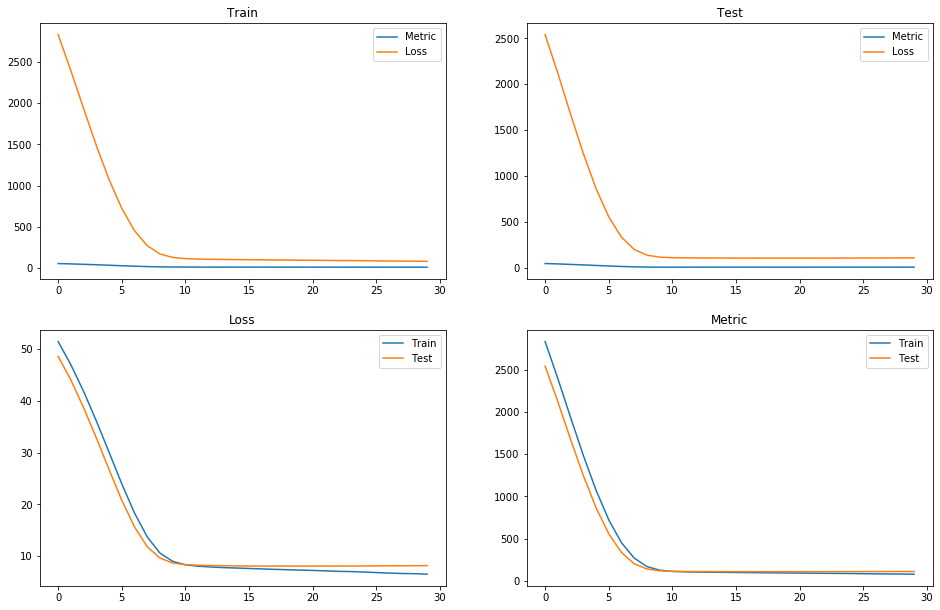

In [25]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [30]:
def get_inputs_subm(idx):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_test/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
    
    k = 2
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
        # padding MRI map
        map_shape = sample_map.shape
        shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                     (map_shape[1]//k + 1)*k - map_shape[1],
                     (map_shape[2]//k + 1)*k - map_shape[2])

        npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

        sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

        sx = sample_map_padded.shape[0] / k
        sy = sample_map_padded.shape[1] / k
        sz = sample_map_padded.shape[2] / k
        for kz in range(k):
            for ky in range(k):
                for kx in range(k):
                    ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                 int(ky*sy): int(ky*sy + sy - 1), 
                                                 int(kz*sz): int(kz*sz + sz - 1)]
                    # padding i-th region by 3 pixels
                    ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                    arr_regions.append(ki_region_padded)
    X_mri = np.stack(arr_regions, axis=3)
    
#     X = (X_mri, X_fnc, X_loading)
    return X_mri, X_fnc, X_loading

In [31]:
y_preds = []
for i in TEST_IDS:
    X_mri, X_fnc, X_loading = get_inputs_subm(i)
    X_mri = X_mri.reshape(1,32, 37, 32, 424)
    X_fnc = X_fnc.reshape(1,1378)
    X_loading = X_loading.reshape(1,26)
    preds = model.predict([X_mri, X_fnc, X_loading], batch_size=1)
    y_preds.append(preds)

In [32]:
len(y_preds)

5877

In [33]:
y_preds = np.array(y_preds).flatten()

In [34]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [35]:
df_submission.to_csv('submission_mri-fnc-load_mae_06.csv', index=False)